In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf

from opt_weights import *
from model_inputs import *
from model import *

notes:
- convert relu to sigmoid
- autoencode - regularize

In [2]:
start_date = datetime.date(2005,1,1)
end_date = datetime.date(2012,5,1)

In [3]:
import pandas.io.data as web
px = web.DataReader(["^GSPC", "^DJI", "^IXIC", "^FCHI", "^FTSE", "^N225"] , 'yahoo', start_date, end_date).Close
ret = px.div(px.shift()).dropna()

/Users/ryanchouck/dev/tf/venv/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


find optimal target regression parameters

In [78]:
#grid = cum_prod_grid(ret, np.exp(np.linspace(-20, 1, 5)), look_ahead_pers=xrange(1,32,10))
grid[grid.norm_type==2].pivot(index='alpha', columns='look_ahead_per', values='cum_ret')

look_ahead_per,1,6,11,16,21,26
alpha,,,,,,
0.000045,1.055490,0.742563,0.794483,0.823825,0.799104,0.832765
0.000172,1.167497,0.774367,0.820112,0.833467,0.813863,0.838289
0.000653,1.159586,0.809981,0.829063,0.849038,0.831213,0.847619
0.002479,0.979250,0.821188,0.835790,0.842870,0.833429,0.846420
0.009404,0.820374,0.795209,0.815550,0.821054,0.808601,0.819515
0.035674,0.767567,0.772356,0.782189,0.781446,0.776878,0.783397
0.135335,0.753885,0.756407,0.760085,0.760716,0.758720,0.761057
0.513417,0.750134,0.750948,0.752049,0.752400,0.751737,0.752458
1.947734,0.749129,0.749357,0.749659,0.749770,0.749582,0.749782


prep model inputs

In [4]:
opt_weights_func = lambda x: calc_opt_weights(x, alpha=0.000653, norm_type=2)
opt_weights = rolling_fit_opt_weights(ret, opt_weights_func, 20)
ys = pd.DataFrame(opt_weights.values, index=opt_weights.index)

Xs = build_Xs_from_returns(ret, 6)

Xs, ys = validate_and_format_Xs_ys(Xs, ys)

model_inputs.py:21: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  weekly = returns_vectors(cum_rets.resample('W', how='last'), per)
model_inputs.py:22: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  monthly = returns_vectors(cum_rets.resample('M', how='last'), per)
model_inputs.py:23: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  quarterly = returns_vectors(cum_rets.resample('Q', how='last'), per)


linear model w softmax

In [3]:
# train, test = split_Xs_ys(Xs, ys, datetime.date(2022,1,1), buffer_days=1)
# Xs, ys = train

In [91]:
#pd.DataFrame(ys).apply(lambda x: list(x).index(max(x)), axis=1).hist()

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


two hidden layer softmax

In [3]:
Xs, ys = mnist.train.next_batch(1500)

In [4]:
from model import *
probs, labels = train_nn_softmax(Xs, ys, mnist, 100, 500, [128, 32, 6])

step     0:	loss: 2.29	(0.12 sec)
step   100:	loss: 2.17	(0.88 sec)
step   200:	loss: 1.94	(1.60 sec)
step   300:	loss: 1.79	(2.25 sec)
step   400:	loss: 1.68	(2.91 sec)
accuracy:	0.574666678905
cross entropy:	1.44401264191


In [5]:
pd.DataFrame(probs).head()

,0,1,2,3,4,5,6,7,8,9
0,0.036146,0.002791,0.088769,0.067826,0.046859,0.077719,0.025269,0.347177,0.023816,0.283627
1,0.010374,0.024776,0.041398,0.597662,0.006836,0.058036,0.005225,0.016165,0.150278,0.089250
2,0.016036,0.002081,0.007093,0.087802,0.260435,0.097287,0.011673,0.066417,0.037599,0.413575
3,0.061730,0.001476,0.086465,0.012579,0.038487,0.084848,0.641332,0.007995,0.050402,0.014687
4,0.003335,0.714275,0.033697,0.034822,0.007644,0.014452,0.030504,0.007718,0.139558,0.013994


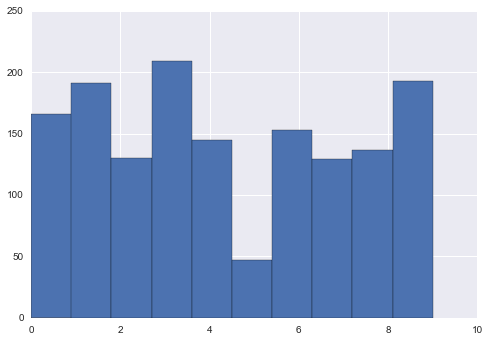

In [6]:
pd.Series(labels).hist()

analytics

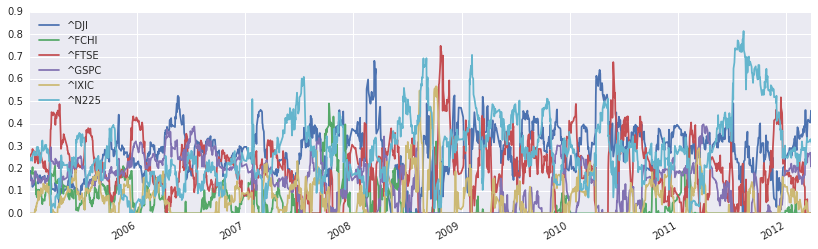

In [92]:
opt_weights.plot(figsize=[14,4])

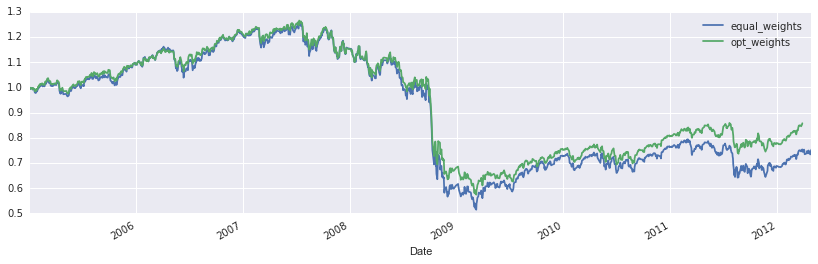

In [93]:
equal_weights = pd.Series({k: 1./ret.shape[1] for k in ret.columns})
perf = pd.DataFrame({'equal_weights': ret.mul(equal_weights).sum(axis=1).cumprod(),
                     'opt_weights': ret.mul(opt_weights).sum(axis=1).cumprod()})

perf.plot(figsize=[14,4])